# Fashion GAN - MNIST

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from keras.layers import Dense, BatchNormalization, Reshape, Input, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.models import Sequential, Model

Using TensorFlow backend.


In [3]:
# Let's see what images fashion_mnist has
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# Functions to plot images
def plot(imgs, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(imgs[0]) is np.ndarray:
        imgs = np.array(imgs).astype(np.uint8)

    fig = plt.figure(figsize=figsize)
    cols = len(imgs)//rows
    for i in range(len(imgs)):
        sp = fig.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

def sample_images(generator, dim, row=5, col=5):
    noise = np.random.normal(0, 1, (row * col, dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(row, col)
    cnt = 0
    for i in range(row):
        for j in range(col):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

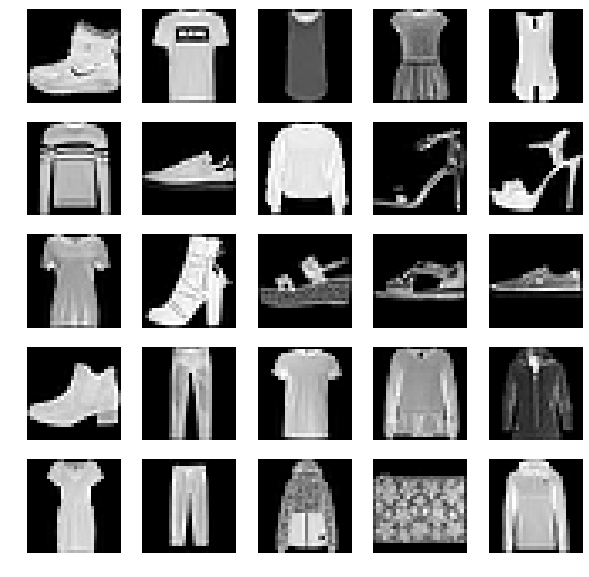

In [5]:
plot(x_train[0:25], rows=5, figsize=(10, 10))

## GAN

### Generator

In [0]:
def model_generator(img_shape, dim):
    model = Sequential()

    model.add(Dense(256, input_dim=dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(dim,))
    img = model(noise)

    return Model(noise, img)

### Discriminator

In [0]:
def model_discriminator(img_shape):
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

### Generate GAN

In [8]:
img_heaight = 28
img_width = 28
channels = 1
dim = 50
img_shape = (img_heaight, img_width, channels)
optimizer = Adam(0.0002, 0.5)

# Create the generator
generator = model_generator(img_shape, dim)

# The generator takes noise as input and output a generated image
noise = Input(shape=(dim,))
img = generator(noise)

# Create the discriminator
discriminator = model_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# The discriminator will not be trained
discriminator.trainable = False

# The discriminator takes the generated images as input and decide if it is valid
validity = discriminator(img)

# Let's combine both models
combined = Model(noise, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)    





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)         

## Train the model!

In [0]:
def train(x_train, generator, discriminator, combined, epochs, dim, batch_size=128, sample_interval=500, acc_interval=250):
        # Rescale -1 to 1
        x_train = x_train / 127.5 - 1.
        x_train = np.expand_dims(x_train, axis=3)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Select a random batch of images
            rand = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[rand]
            noise = np.random.normal(0, 1, (batch_size, dim))

            # TRAIN THE DISCRIMINATOR
            # Generate a batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # TRAIN THE GENERATOR
            noise = np.random.normal(0, 1, (batch_size, dim))

            # Train the generator to have the discriminator label samples as valid
            g_loss = combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % acc_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                sample_images(generator, dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.032662, acc.: 100.00%] [G loss: 3.993111]


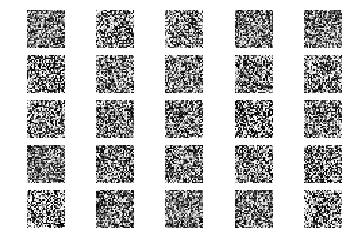

250 [D loss: 0.609367, acc.: 70.31%] [G loss: 1.112193]
500 [D loss: 0.639901, acc.: 60.94%] [G loss: 0.914009]


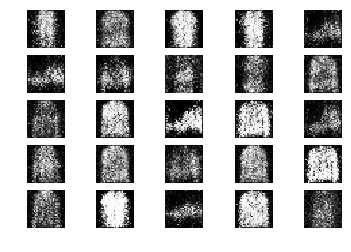

750 [D loss: 0.629638, acc.: 68.75%] [G loss: 0.845449]
1000 [D loss: 0.681638, acc.: 50.00%] [G loss: 0.829809]


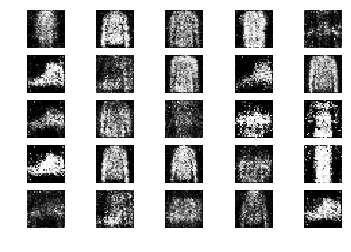

1250 [D loss: 0.651492, acc.: 50.00%] [G loss: 0.924796]
1500 [D loss: 0.609426, acc.: 70.31%] [G loss: 0.951373]


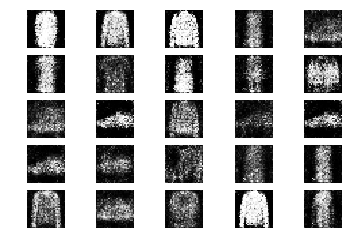

1750 [D loss: 0.593640, acc.: 71.88%] [G loss: 0.909987]
2000 [D loss: 0.653429, acc.: 62.50%] [G loss: 0.921028]


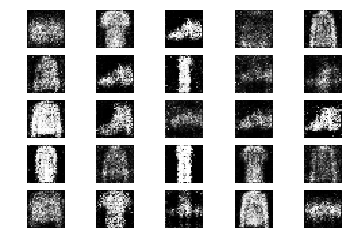

2250 [D loss: 0.658377, acc.: 57.81%] [G loss: 1.013322]
2500 [D loss: 0.584483, acc.: 71.88%] [G loss: 0.986463]


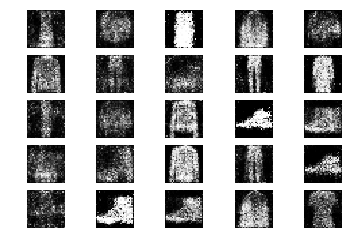

2750 [D loss: 0.646791, acc.: 62.50%] [G loss: 0.866053]
3000 [D loss: 0.608507, acc.: 67.19%] [G loss: 0.858999]


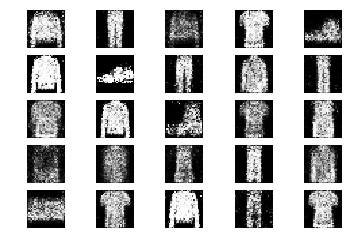

3250 [D loss: 0.576500, acc.: 70.31%] [G loss: 0.886705]
3500 [D loss: 0.695285, acc.: 53.12%] [G loss: 0.805170]


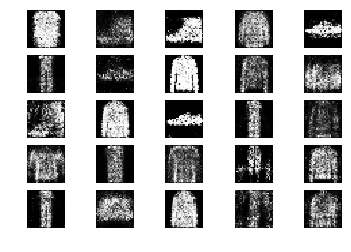

3750 [D loss: 0.695890, acc.: 51.56%] [G loss: 0.863087]
4000 [D loss: 0.632539, acc.: 67.19%] [G loss: 0.800906]


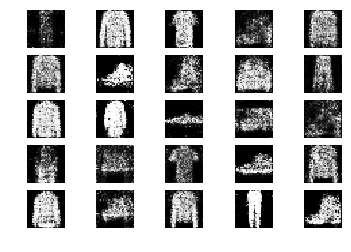

4250 [D loss: 0.692386, acc.: 59.38%] [G loss: 0.843059]
4500 [D loss: 0.728426, acc.: 56.25%] [G loss: 0.908624]


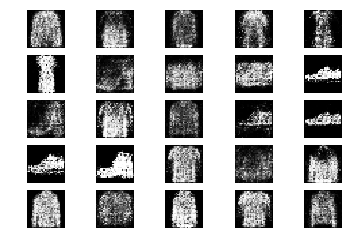

4750 [D loss: 0.660206, acc.: 57.81%] [G loss: 0.916020]
5000 [D loss: 0.676746, acc.: 60.94%] [G loss: 0.873652]


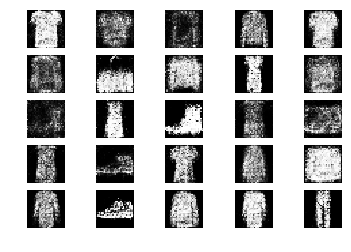

5250 [D loss: 0.733743, acc.: 54.69%] [G loss: 0.872333]
5500 [D loss: 0.605367, acc.: 71.88%] [G loss: 0.845145]


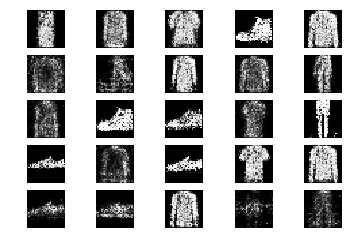

5750 [D loss: 0.652448, acc.: 65.62%] [G loss: 0.819183]
6000 [D loss: 0.624092, acc.: 64.06%] [G loss: 0.871277]


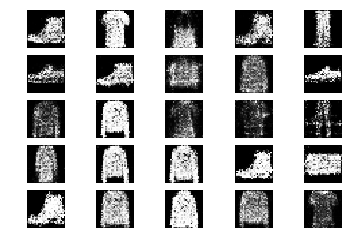

6250 [D loss: 0.725009, acc.: 46.88%] [G loss: 0.936754]
6500 [D loss: 0.675031, acc.: 56.25%] [G loss: 0.860885]


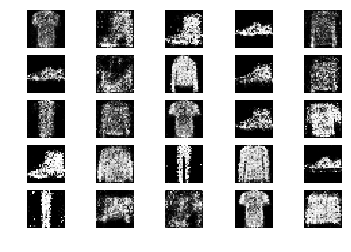

6750 [D loss: 0.687323, acc.: 56.25%] [G loss: 0.899370]
7000 [D loss: 0.659785, acc.: 64.06%] [G loss: 0.954287]


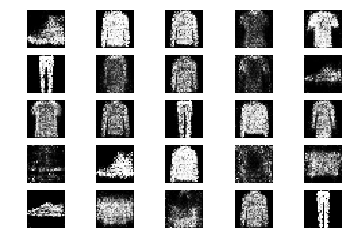

7250 [D loss: 0.667622, acc.: 56.25%] [G loss: 0.934478]
7500 [D loss: 0.662967, acc.: 57.81%] [G loss: 0.886096]


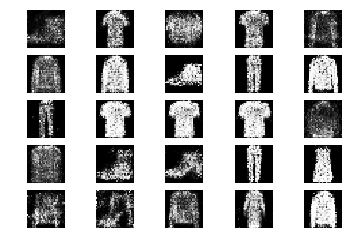

7750 [D loss: 0.643206, acc.: 60.94%] [G loss: 0.844079]
8000 [D loss: 0.719327, acc.: 56.25%] [G loss: 0.901943]


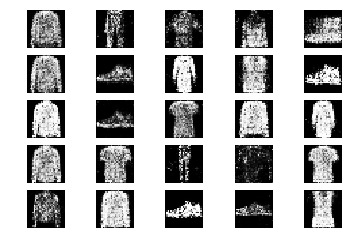

8250 [D loss: 0.639508, acc.: 65.62%] [G loss: 0.870944]
8500 [D loss: 0.632683, acc.: 56.25%] [G loss: 0.918427]


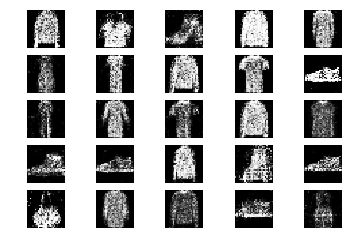

8750 [D loss: 0.653001, acc.: 59.38%] [G loss: 0.791965]
9000 [D loss: 0.592447, acc.: 73.44%] [G loss: 0.955279]


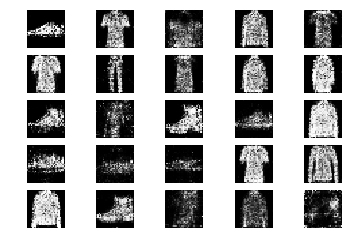

9250 [D loss: 0.671132, acc.: 57.81%] [G loss: 0.876444]
9500 [D loss: 0.611710, acc.: 62.50%] [G loss: 0.904946]


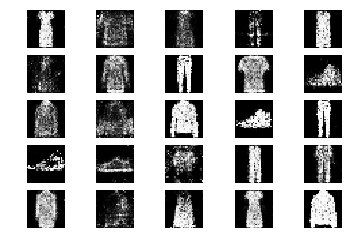

9750 [D loss: 0.652020, acc.: 60.94%] [G loss: 0.876263]
10000 [D loss: 0.606894, acc.: 67.19%] [G loss: 0.844949]


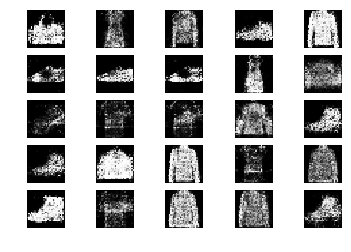

10250 [D loss: 0.617427, acc.: 67.19%] [G loss: 0.839442]
10500 [D loss: 0.706129, acc.: 54.69%] [G loss: 0.836684]


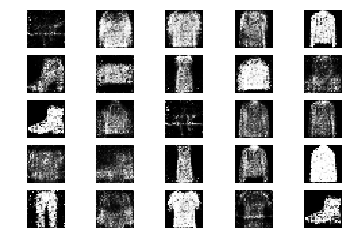

10750 [D loss: 0.699281, acc.: 45.31%] [G loss: 0.864946]
11000 [D loss: 0.667101, acc.: 57.81%] [G loss: 0.850434]


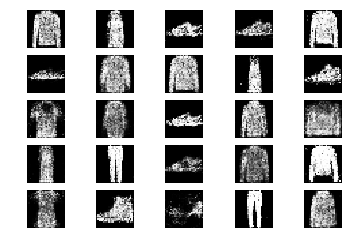

11250 [D loss: 0.711967, acc.: 51.56%] [G loss: 0.893749]
11500 [D loss: 0.649277, acc.: 57.81%] [G loss: 0.979382]


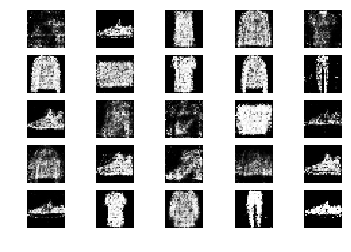

11750 [D loss: 0.609657, acc.: 70.31%] [G loss: 0.853585]
12000 [D loss: 0.700202, acc.: 53.12%] [G loss: 0.901449]


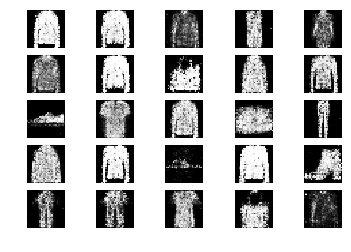

12250 [D loss: 0.635168, acc.: 64.06%] [G loss: 0.903347]
12500 [D loss: 0.645446, acc.: 60.94%] [G loss: 0.931569]


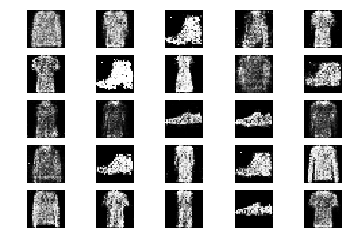

12750 [D loss: 0.649257, acc.: 59.38%] [G loss: 0.864535]
13000 [D loss: 0.615723, acc.: 67.19%] [G loss: 0.829747]


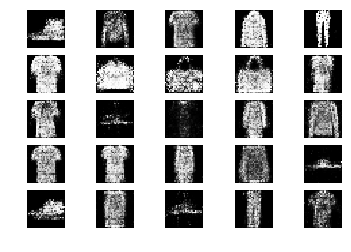

13250 [D loss: 0.657341, acc.: 60.94%] [G loss: 0.970708]
13500 [D loss: 0.733944, acc.: 46.88%] [G loss: 0.912079]


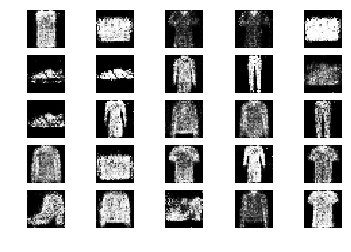

13750 [D loss: 0.696630, acc.: 53.12%] [G loss: 0.878793]
14000 [D loss: 0.645480, acc.: 68.75%] [G loss: 0.869326]


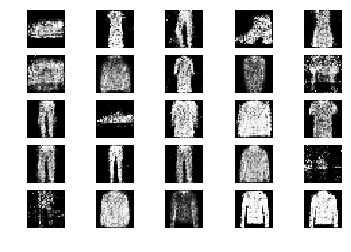

14250 [D loss: 0.639520, acc.: 65.62%] [G loss: 0.845751]
14500 [D loss: 0.615024, acc.: 68.75%] [G loss: 0.957147]


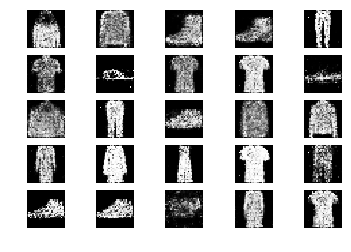

14750 [D loss: 0.667261, acc.: 54.69%] [G loss: 0.891817]
15000 [D loss: 0.683270, acc.: 56.25%] [G loss: 0.847292]


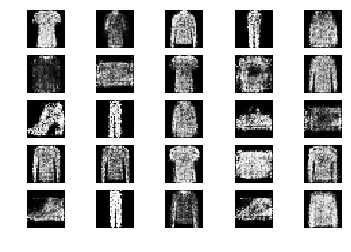

15250 [D loss: 0.654545, acc.: 53.12%] [G loss: 0.907386]
15500 [D loss: 0.618737, acc.: 71.88%] [G loss: 0.904997]


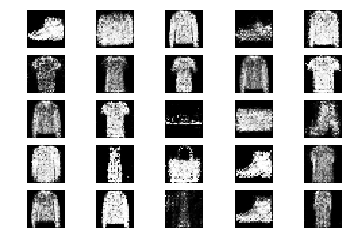

15750 [D loss: 0.662218, acc.: 60.94%] [G loss: 0.982125]
16000 [D loss: 0.610633, acc.: 71.88%] [G loss: 0.875389]


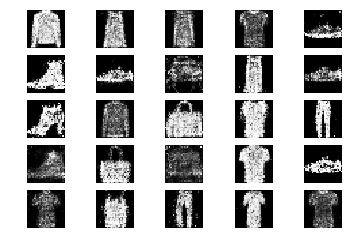

16250 [D loss: 0.680119, acc.: 57.81%] [G loss: 0.986430]
16500 [D loss: 0.672481, acc.: 56.25%] [G loss: 0.986783]


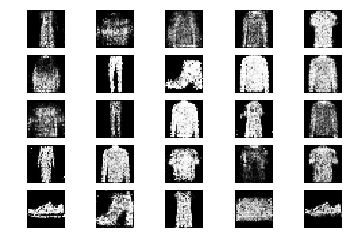

16750 [D loss: 0.669228, acc.: 59.38%] [G loss: 0.841487]
17000 [D loss: 0.633620, acc.: 68.75%] [G loss: 0.898870]


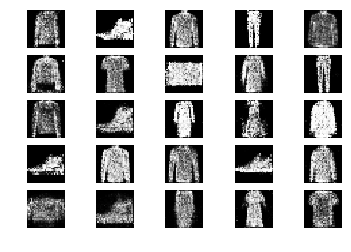

17250 [D loss: 0.674257, acc.: 56.25%] [G loss: 0.924883]
17500 [D loss: 0.693974, acc.: 53.12%] [G loss: 0.812396]


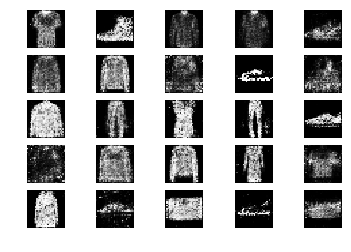

17750 [D loss: 0.680242, acc.: 59.38%] [G loss: 0.831319]
18000 [D loss: 0.640700, acc.: 59.38%] [G loss: 0.814619]


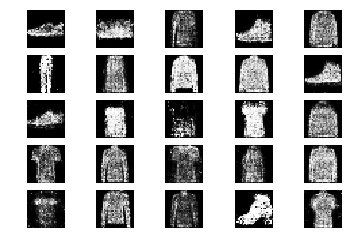

18250 [D loss: 0.585913, acc.: 75.00%] [G loss: 0.867693]
18500 [D loss: 0.654658, acc.: 57.81%] [G loss: 0.882534]


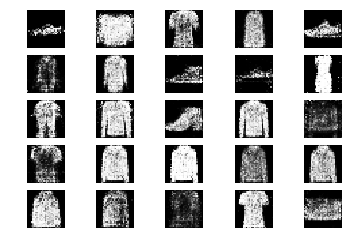

18750 [D loss: 0.642918, acc.: 57.81%] [G loss: 0.889405]
19000 [D loss: 0.643673, acc.: 64.06%] [G loss: 0.908230]


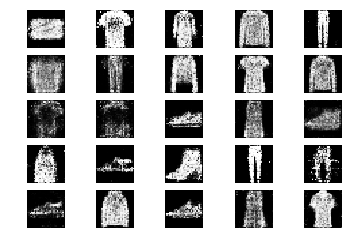

19250 [D loss: 0.657744, acc.: 53.12%] [G loss: 0.934579]
19500 [D loss: 0.611178, acc.: 68.75%] [G loss: 0.845863]


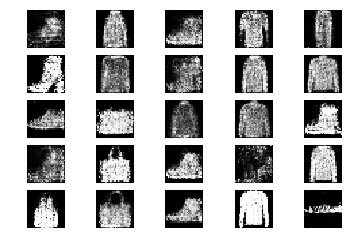

19750 [D loss: 0.711599, acc.: 53.12%] [G loss: 0.894511]


In [18]:
epochs = 20000
train(x_train, generator, discriminator, combined, epochs, dim, batch_size=32)

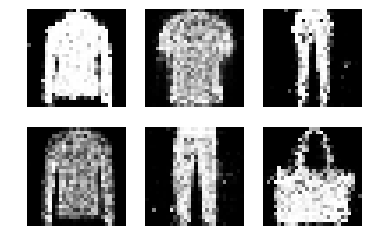

In [47]:
# Print 6 random generated examples
sample_images(generator, dim, row=2, col=3)